# CKA

#### Dataset generator

In [17]:
# Divergencia de modelos
# Fedavg post prodcesado sacar nueva cka
# cdf: Nothing, model anticipation, plane FL, global FL
# average del plano y average total
# simulacion despues de fedavg check capabilities
# fed CDF

import os
import glob
import numpy as np

def generate_test_data(num_samples, include_not_avail=False):
    data = []
    queue_values = np.arange(0, 11)  # Possible queue values from 0 to 10
    # Set probabilities: 0 at 35%, 10 at 20%, and 5% each for values 1-9
    queue_probs = [0.35] + [0.05] * 9 + [0.20]

    for _ in range(num_samples):
        sample = []
        # Queue Scores for each direction: Up, Down, Right, Left (4 scores each)
        for _ in range(4):
            # Queue scores biased towards 0 and 10
            sample.extend(np.random.choice(queue_values, 4, p=queue_probs))
            
            # Relative positions for each direction: latitude and longitude
            sample.append(np.random.uniform(-2, 2))  # Latitude relative position
            sample.append(np.random.uniform(-2, 2))  # Longitude relative position
        
        # Absolute positions
        sample.append(np.random.uniform(0, 9))  # Absolute latitude normalized
        sample.append(np.random.uniform(0, 18))  # Absolute longitude normalized
        
        # Destination differential coordinates
        sample.append(np.random.uniform(-2, 2))  # Destination differential latitude
        sample.append(np.random.uniform(-2, 2))  # Destination differential longitude
        
        # Optionally include not available values
        if include_not_avail and np.random.rand() < 0.1:  # 10% chance to introduce a -1 value
            idx_to_replace = np.random.choice(len(sample), int(0.1 * len(sample)), replace=False)
            sample[idx_to_replace] = -1
        
        data.append(sample)
    
    return np.array(data)

def get_model_paths(folder, nGTs):
    # Create an empty list to hold all file paths
    model_files = []
    
    # Iterate over the range of first and second digit as specified
    for i in range(nPlanes):  # from 0 to 6
        for j in range(nSats):  # from 0 to 19
            # Construct the pattern for each file
            pattern = os.path.join(folder, f"{i}_{j}qNetwork_{nGTs}GTs.h5")
            # Use glob to find files matching the current pattern
            files = glob.glob(pattern)
            # Add found files to the list
            model_files.extend(files)
    
    # Sort the files to maintain a consistent order
    # model_files.sort()
    
    return model_files

# Model paths
nPlanes = 7#7
nSats   = 20#20
nGTs = 8
secs = 1
con  = 'con'    # ['nocon' (no congestion), 'con' (congestion)]
folder_path = f'./FL/NNs_{nGTs}GTs_{secs}s_{con}/'
model_paths = get_model_paths(folder_path, nGTs)
print(model_paths)

# Generate dataset
num_samples = 100  # Number of state vectors to generate
test_data = generate_test_data(num_samples)

print("Sample data shape:", test_data.shape)
print("Sample data:", test_data[:5])  # Print the first 5 samples to check



['./FL/NNs_8GTs_1s_con/0_0qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_1qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_2qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_3qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_4qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_5qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_6qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_7qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_8qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_9qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_10qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_11qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_12qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_13qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_14qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_15qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_16qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_17qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_18qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/0_19qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/1_0qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con/1_1qNetwork_8GTs.h5', './FL/NNs_8GTs_1s_con

#### CKA, FL and CDF

In [25]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def load_models(model_paths):
    """Load all models from given paths."""
    return [load_model(path) for path in model_paths]

def gram_matrix(X):
    """Calculate the Gram matrix from layer activations."""
    n = X.shape[0]
    X = X - X.mean(axis=0)
    return X @ X.T / n

def cka(G, H):
    """Compute the CKA metric."""
    return np.trace(G @ H) / np.sqrt(np.trace(G @ G) * np.trace(H @ H))

def compute_cka(model1, model2, data):
    """Compute the CKA between layers of two models using data."""
    intermediate_model1 = tf.keras.Model(inputs=model1.input, outputs=[layer.output for layer in model1.layers])
    intermediate_model2 = tf.keras.Model(inputs=model2.input, outputs=[layer.output for layer in model2.layers])
    activations1 = intermediate_model1(data)
    activations2 = intermediate_model2(data)
    return np.mean([cka(gram_matrix(np.array(act1)), gram_matrix(np.array(act2))) for act1, act2 in zip(activations1, activations2)])

def compute_full_cka_matrix(models, data):
    """Compute the full CKA matrix for a list of models."""
    n = len(models)
    cka_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if i == j:
                cka_matrix[i, j] = 1.0
            else:
                cka_matrix[i, j] = cka_matrix[j, i] = compute_cka(models[i], models[j], data)
    return cka_matrix

def plot_cka_heatmap(cka_matrix, model_names, title, vmin, vmax, xlim=None, ylim=None):
    sns.set(style="white")
    plt.figure(figsize=(8, 6))
    labels = []
    previous_label = None
    for name in model_names:
        current_label = name.split('_')[0]
        if current_label != previous_label:
            labels.append(str(int(current_label) + 1))
            previous_label = current_label
        else:
            labels.append('')
    ax = sns.heatmap(cka_matrix, annot=False, fmt=".2f", cmap="coolwarm_r",
                     xticklabels=labels, yticklabels=labels,
                     square=True, linewidths=.1, cbar_kws={"shrink": .8, "label": "CKA"},
                     vmin=vmin, vmax=vmax)
    ax.set_xlabel('Orbital Plane')
    ax.set_ylabel('Orbital Plane')
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    # plt.title(title)
    plt.savefig(f'./FL/CKA_{title}.png', bbox_inches='tight', dpi=500)
    plt.show()

def plot_combined_cka_cdf(cka_matrices, labels):
    """Plot the cumulative distribution function (CDF) for multiple CKA matrices."""
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4), facecolor='white')
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')
    
    for cka_matrix, label in zip(cka_matrices, labels):
        cka_values = cka_matrix[np.triu_indices_from(cka_matrix, k=1)]
        sorted_values = np.sort(cka_values)
        plt.step(sorted_values, np.linspace(0, 1, len(sorted_values), endpoint=True), where='post', label=label)
    
    plt.xlim([0, 1.05])
    plt.ylim([0, 1])
    plt.xlabel('CKA Value', fontsize=16)
    plt.ylabel('CDF', fontsize=16)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig('./FL/CKA_CDF.png', bbox_inches='tight', dpi=500)
    plt.show()

def average_model_weights(models):
    """Average weights of multiple trained models."""
    weights = [model.get_weights() for model in models]
    new_weights = [np.mean(np.array(w), axis=0) for w in zip(*weights)]
    return new_weights

def federate_by_plane(models, model_names):
    """Perform Federated Averaging within each orbital plane."""
    plane_dict = {}
    for model, name in zip(models, model_names):
        plane = name.split('_')[0]
        if plane in plane_dict:
            plane_dict[plane].append(model)
        else:
            plane_dict[plane] = [model]
    for plane_models in plane_dict.values():
        averaged_weights = average_model_weights(plane_models)
        for model in plane_models:
            model.set_weights(averaged_weights)

def model_anticipation_federate(models, model_names):
    """Perform Model Anticipation Federated Learning."""
    plane_dict = {}
    # Group models by orbital plane
    for model, name in zip(models, model_names):
        plane = name.split('_')[0]
        if plane not in plane_dict:
            plane_dict[plane] = []
        plane_dict[plane].append((model, name))
    
    # Process each plane for model anticipation
    for plane_models in plane_dict.values():
        # Sort models by their identifiers within the plane
        plane_models.sort(key=lambda x: int(x[1].split('_')[1]))
        for i in range(1, len(plane_models)):
            prev_model_weights = plane_models[i - 1][0].get_weights()
            current_model = plane_models[i][0]
            current_weights = current_model.get_weights()
            # Average weights from the previous model
            new_weights = [(w1 + w2) / 2 for w1, w2 in zip(current_weights, prev_model_weights)]
            current_model.set_weights(new_weights)

def compute_average_cka(cka_matrix):
    """Compute the average CKA value from a CKA matrix."""
    triu_indices = np.triu_indices_from(cka_matrix, k=1)
    return np.mean(cka_matrix[triu_indices])

def compute_percentile_improvements(original_cka, new_cka, percentiles=[10, 25, 50, 90, 95]):
    """Compute the improvements in specified percentiles of CKA values."""
    original_values = original_cka[np.triu_indices_from(original_cka, k=1)]
    new_values = new_cka[np.triu_indices_from(new_cka, k=1)]
    
    improvements = {}
    for p in percentiles:
        original_percentile = np.percentile(original_values, p)
        new_percentile = np.percentile(new_values, p)
        improvement = (new_percentile - original_percentile) / original_percentile * 100
        improvements[p] = improvement
    
    return improvements

def perform_extended_federated_cka_analysis(model_paths, test_data):
    models = load_models(model_paths)
    model_names = [path.split('/')[-1].split('qNetwork')[0].rstrip('_') for path in model_paths]

    # Compute CKA matrices for various scenarios
    original_cka_matrix = compute_full_cka_matrix(models, test_data)
    anticipation_models = load_models(model_paths)
    model_anticipation_federate(anticipation_models, model_names)
    anticipation_cka_matrix = compute_full_cka_matrix(anticipation_models, test_data)
    models_by_plane = load_models(model_paths)
    federate_by_plane(models_by_plane, model_names)
    by_plane_cka_matrix = compute_full_cka_matrix(models_by_plane, test_data)
    models_constellation = load_models(model_paths)
    averaged_weights = average_model_weights(models_constellation)
    for model in models_constellation:
        model.set_weights(averaged_weights)
    fedavg_cka_matrix = compute_full_cka_matrix(models_constellation, test_data)

    # Compute average CKA values
    avg_cka_original = compute_average_cka(original_cka_matrix)
    avg_cka_anticipation = compute_average_cka(anticipation_cka_matrix)
    avg_cka_by_plane = compute_average_cka(by_plane_cka_matrix)
    avg_cka_fedavg = compute_average_cka(fedavg_cka_matrix)

    # Compute CKA improvement
    improvement_anticipation = (avg_cka_anticipation - avg_cka_original) / avg_cka_original * 100
    improvement_by_plane = (avg_cka_by_plane - avg_cka_original) / avg_cka_original * 100
    improvement_fedavg = (avg_cka_fedavg - avg_cka_original) / avg_cka_original * 100

    print(f"Average CKA - Original: {avg_cka_original:.4f}")
    print(f"Average CKA - Model Anticipation: {avg_cka_anticipation:.4f} ({improvement_anticipation:.2f}% improvement)")
    print(f"Average CKA - Federated by Plane: {avg_cka_by_plane:.4f} ({improvement_by_plane:.2f}% improvement)")
    print(f"Average CKA - FedAvg Constellation: {avg_cka_fedavg:.4f} ({improvement_fedavg:.2f}% improvement)")

    # Compute percentile improvements
    percentiles = [10, 25, 50, 90, 95]
    percentile_improvements_anticipation = compute_percentile_improvements(original_cka_matrix, anticipation_cka_matrix, percentiles)
    percentile_improvements_by_plane = compute_percentile_improvements(original_cka_matrix, by_plane_cka_matrix, percentiles)
    percentile_improvements_fedavg = compute_percentile_improvements(original_cka_matrix, fedavg_cka_matrix, percentiles)
    
    for p in percentiles:
        print(f"Percentile {p} CKA Improvement - Model Anticipation: {percentile_improvements_anticipation[p]:.2f}%")
        print(f"Percentile {p} CKA Improvement - Federated by Plane: {percentile_improvements_by_plane[p]: .2f}%")
        print(f"Percentile {p} CKA Improvement - FedAvg Constellation: {percentile_improvements_fedavg[p]: .2f}%")

    # Determine colormap limits for the first two figures
    first_two_matrices = [original_cka_matrix, anticipation_cka_matrix]
    vmin_first_two = min(matrix.min() for matrix in first_two_matrices)
    vmax_first_two = max(matrix.max() for matrix in first_two_matrices)

    # Determine colormap limits for the last two figures
    last_two_matrices = [by_plane_cka_matrix, fedavg_cka_matrix]
    vmin_last_two = min(matrix.min() for matrix in last_two_matrices)
    vmax_last_two = max(matrix.max() for matrix in last_two_matrices)

    # Plot each CKA heatmap with the respective colormap scale
    plot_cka_heatmap(original_cka_matrix, model_names, "Original CKA Matrix", vmin_first_two, vmax_first_two)
    plot_cka_heatmap(anticipation_cka_matrix, model_names, "Model Anticipation FL CKA Matrix", vmin_first_two, vmax_first_two)
    plot_cka_heatmap(by_plane_cka_matrix, model_names, "Federated Learning by Plane CKA Matrix", vmin_last_two, vmax_last_two)
    plot_cka_heatmap(fedavg_cka_matrix, model_names, "FedAvg Constellation CKA Matrix", vmin_last_two, vmax_last_two)

    # Plot CDF for all scenarios
    plot_combined_cka_cdf([original_cka_matrix, anticipation_cka_matrix, by_plane_cka_matrix, fedavg_cka_matrix],
                          ["Without alignment", "Model Anticipation", "Orbital plane aggregation (SFL)", "Full aggregation (SFL)"])

# Example usage
perform_extended_federated_cka_analysis(model_paths, test_data)
 

In [4]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def load_models(model_paths):
    """Load all models from given paths."""
    return [load_model(path) for path in model_paths]

def gram_matrix(X):
    """Calculate the Gram matrix from layer activations."""
    n = X.shape[0]
    X = X - X.mean(axis=0)
    return X @ X.T / n

def cka(G, H):
    """Compute the CKA metric."""
    return np.trace(G @ H) / np.sqrt(np.trace(G @ G) * np.trace(H @ H))

def compute_cka(model1, model2, data):
    """Compute the CKA between layers of two models using data."""
    intermediate_model1 = tf.keras.Model(inputs=model1.input, outputs=[layer.output for layer in model1.layers])
    intermediate_model2 = tf.keras.Model(inputs=model2.input, outputs=[layer.output for layer in model2.layers])
    activations1 = intermediate_model1(data)
    activations2 = intermediate_model2(data)
    return np.mean([cka(gram_matrix(np.array(act1)), gram_matrix(np.array(act2))) for act1, act2 in zip(activations1, activations2)])

def compute_full_cka_matrix(models, data):
    """Compute the full CKA matrix for a list of models."""
    n = len(models)
    cka_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if i == j:
                cka_matrix[i, j] = 1.0
            else:
                cka_matrix[i, j] = cka_matrix[j, i] = compute_cka(models[i], models[j], data)
    return cka_matrix

def plot_cka_heatmap(cka_matrix, model_names, title, vmin, vmax, xlim=None, ylim=None):
    sns.set(style="white")
    plt.figure(figsize=(8, 6))
    labels = []
    previous_label = None
    for name in model_names:
        current_label = name.split('_')[0]
        if current_label != previous_label:
            labels.append(str(int(current_label) + 1))
            previous_label = current_label
        else:
            labels.append('')
    ax = sns.heatmap(cka_matrix, annot=False, fmt=".2f", cmap="coolwarm_r",
                     xticklabels=labels, yticklabels=labels,
                     square=True, linewidths=.1, cbar_kws={"shrink": .8, "label": "CKA"},
                     vmin=vmin, vmax=vmax)
    ax.set_xlabel('Orbital Plane')
    ax.set_ylabel('Orbital Plane')
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    plt.savefig(f'./FL/CKA_{title}.png', bbox_inches='tight', dpi=500)
    plt.show()

def plot_combined_cka_cdf(cka_matrices, labels):
    """Plot the cumulative distribution function (CDF) for multiple CKA matrices."""
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6), facecolor='white')
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')
    
    for cka_matrix, label in zip(cka_matrices, labels):
        cka_values = cka_matrix[np.triu_indices_from(cka_matrix, k=1)]
        sorted_values = np.sort(cka_values)
        plt.step(sorted_values, np.linspace(0, 1, len(sorted_values), endpoint=True), where='post', label=label)
        
        # Add discontinuous line for 50th percentile
        percentile_50 = np.percentile(cka_values, 50)
        plt.axvline(x=percentile_50, color=plt.gca().lines[-1].get_color(), linestyle='--')
        plt.text(percentile_50 - 0.01, 0.5, f'{percentile_50:.2f}', color=plt.gca().lines[-1].get_color(), fontsize=12, ha='right', va='center')
    
    plt.xlim([0, 1.05])
    plt.ylim([0, 1])
    plt.xlabel('CKA Value')
    plt.ylabel('CDF')
    plt.legend()
    plt.savefig('./FL/CKA_CDF.png', bbox_inches='tight', dpi=500)
    plt.show()

def average_model_weights(models):
    """Average weights of multiple trained models."""
    weights = [model.get_weights() for model in models]
    new_weights = [np.mean(np.array(w), axis=0) for w in zip(*weights)]
    return new_weights

def federate_by_plane(models, model_names):
    """Perform Federated Averaging within each orbital plane."""
    plane_dict = {}
    for model, name in zip(models, model_names):
        plane = name.split('_')[0]
        if plane in plane_dict:
            plane_dict[plane].append(model)
        else:
            plane_dict[plane] = [model]
    for plane_models in plane_dict.values():
        averaged_weights = average_model_weights(plane_models)
        for model in plane_models:
            model.set_weights(averaged_weights)

def model_anticipation_federate(models, model_names):
    """Perform Model Anticipation Federated Learning."""
    plane_dict = {}
    # Group models by orbital plane
    for model, name in zip(models, model_names):
        plane = name.split('_')[0]
        if plane not in plane_dict:
            plane_dict[plane] = []
        plane_dict[plane].append((model, name))
    
    # Process each plane for model anticipation
    for plane_models in plane_dict.values():
        # Sort models by their identifiers within the plane
        plane_models.sort(key=lambda x: int(x[1].split('_')[1]))
        for i in range(1, len(plane_models)):
            prev_model_weights = plane_models[i - 1][0].get_weights()
            current_model = plane_models[i][0]
            current_weights = current_model.get_weights()
            # Average weights from the previous model
            new_weights = [(w1 + w2) / 2 for w1, w2 in zip(current_weights, prev_model_weights)]
            current_model.set_weights(new_weights)

def compute_average_cka(cka_matrix):
    """Compute the average CKA value from a CKA matrix."""
    triu_indices = np.triu_indices_from(cka_matrix, k=1)
    return np.mean(cka_matrix[triu_indices])

def compute_percentile_improvements(original_cka, new_cka, percentiles=[50, 90, 95]):
    """Compute the improvements in specified percentiles of CKA values."""
    original_values = original_cka[np.triu_indices_from(original_cka, k=1)]
    new_values = new_cka[np.triu_indices_from(new_cka, k=1)]
    
    improvements = {}
    for p in percentiles:
        original_percentile = np.percentile(original_values, p)
        new_percentile = np.percentile(new_values, p)
        improvement = (new_percentile - original_percentile) / original_percentile * 100
        improvements[p] = improvement
    
    return improvements

def perform_extended_federated_cka_analysis(model_paths, test_data):
    models = load_models(model_paths)
    model_names = [path.split('/')[-1].split('qNetwork')[0].rstrip('_') for path in model_paths]

    # Compute CKA matrices for various scenarios
    original_cka_matrix = compute_full_cka_matrix(models, test_data)
    anticipation_models = load_models(model_paths)
    model_anticipation_federate(anticipation_models, model_names)
    anticipation_cka_matrix = compute_full_cka_matrix(anticipation_models, test_data)
    models_by_plane = load_models(model_paths)
    federate_by_plane(models_by_plane, model_names)
    by_plane_cka_matrix = compute_full_cka_matrix(models_by_plane, test_data)
    models_constellation = load_models(model_paths)
    averaged_weights = average_model_weights(models_constellation)
    for model in models_constellation:
        model.set_weights(averaged_weights)
    fedavg_cka_matrix = compute_full_cka_matrix(models_constellation, test_data)

    # Compute average CKA values
    avg_cka_original = compute_average_cka(original_cka_matrix)
    avg_cka_anticipation = compute_average_cka(anticipation_cka_matrix)
    avg_cka_by_plane = compute_average_cka(by_plane_cka_matrix)
    avg_cka_fedavg = compute_average_cka(fedavg_cka_matrix)

    # Compute CKA improvement
    improvement_anticipation = (avg_cka_anticipation - avg_cka_original) / avg_cka_original * 100
    improvement_by_plane = (avg_cka_by_plane - avg_cka_original) / avg_cka_original * 100
    improvement_fedavg = (avg_cka_fedavg - avg_cka_original) / avg_cka_original * 100

    # Compute percentile improvements
    percentiles = [50, 90, 95]
    percentile_improvements_anticipation = compute_percentile_improvements(original_cka_matrix, anticipation_cka_matrix, percentiles)
    percentile_improvements_by_plane = compute_percentile_improvements(original_cka_matrix, by_plane_cka_matrix, percentiles)
    percentile_improvements_fedavg = compute_percentile_improvements(original_cka_matrix, fedavg_cka_matrix, percentiles)

    print(f"Average CKA - Original: {avg_cka_original:.4f}")
    print(f"Average CKA - Model Anticipation: {avg_cka_anticipation:.4f} ({improvement_anticipation:.2f}% improvement)")
    print(f"Average CKA - Federated by Plane: {avg_cka_by_plane:.4f} ({improvement_by_plane:.2f}% improvement)")
    print(f"Average CKA - FedAvg Constellation: {avg_cka_fedavg:.4f} ({improvement_fedavg:.2f}% improvement)")

    for p in percentiles:
        print(f"Percentile {p} CKA Improvement - Model Anticipation: {percentile_improvements_anticipation[p]:.2f}%")
        print(f"Percentile {p} CKA Improvement - Federated by Plane: {percentile_improvements_by_plane[p]: .2f}%")
        print(f"Percentile {p} CKA Improvement - FedAvg Constellation: {percentile_improvements_fedavg[p]: .2f}%")

    # Determine colormap limits for the first two figures
    first_two_matrices = [original_cka_matrix, anticipation_cka_matrix]
    vmin_first_two = min(matrix.min() for matrix in first_two_matrices)
    vmax_first_two = max(matrix.max() for matrix in first_two_matrices)

    # Determine colormap limits for the last two figures
    last_two_matrices = [by_plane_cka_matrix, fedavg_cka_matrix]
    vmin_last_two = min(matrix.min() for matrix in last_two_matrices)
    vmax_last_two = max(matrix.max() for matrix in last_two_matrices)

    # Plot each CKA heatmap with the respective colormap scale
    plot_cka_heatmap(original_cka_matrix, model_names, "Original CKA Matrix", vmin_first_two, vmax_first_two)
    plot_cka_heatmap(anticipation_cka_matrix, model_names, "Model Anticipation FL CKA Matrix", vmin_first_two, vmax_first_two)
    plot_cka_heatmap(by_plane_cka_matrix, model_names, "Federated Learning by Plane CKA Matrix", vmin_last_two, vmax_last_two)
    plot_cka_heatmap(fedavg_cka_matrix, model_names, "FedAvg Constellation CKA Matrix", vmin_last_two, vmax_last_two)

    # Plot CDF for all scenarios
    plot_combined_cka_cdf([original_cka_matrix, anticipation_cka_matrix, by_plane_cka_matrix, fedavg_cka_matrix],
                          ["Without alignment", "Model Anticipation", "Orbital plane aggregation (SFL)", "Full aggregation (SFL)"])

# Example usage
# model_paths = ["model1_path", "model2_path", "model3_path"]  # Replace with actual paths
# test_data = np.random.random((100, 224, 224, 3))  # Replace with actual test data
# perform_extended_federated_cka_analysis(model_paths, test_data)


# Deterministic box plot

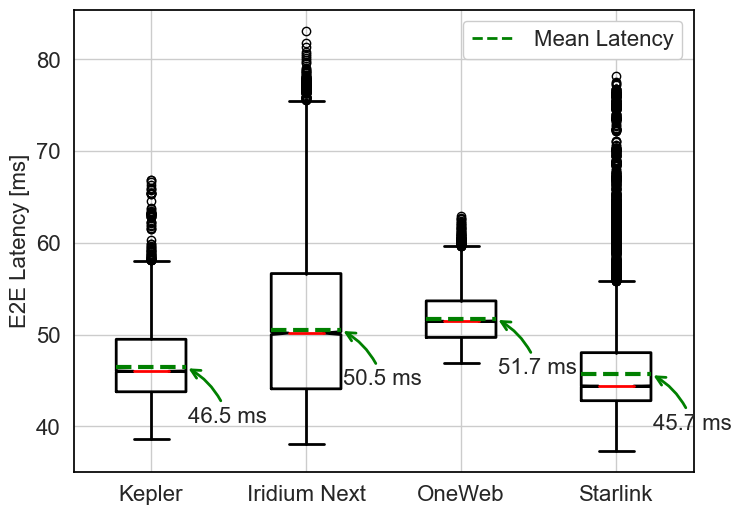

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def plot_satellite_latencies(file_paths):
    """
    Generates a boxplot for latencies by satellite constellation from given file paths.
    
    Args:
    file_paths (list of str): List of file paths for latency data for each satellite constellation.
    
    The function assumes that the files are in the format of:
    - file_paths[0]: Kepler data
    - file_paths[1]: Iridium data
    - file_paths[2]: OneWeb data
    - file_paths[3]: Starlink data
    """
    dataframes = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        # Filter the data for packets going from Malaga, Spain to Los Angeles, USA
        filtered_df = df[(df['Source'] == "Malaga, Spain") & (df['Destination'] == "Los Angeles, California, US")]
        dataframes.append(filtered_df['Latency'] * 1000)  # Convert seconds to milliseconds
    
    # Set visual settings
    sns.set(font_scale=1.0)
    sns.set_style("whitegrid")

    # Plotting the boxplot
    plt.figure(figsize=(8, 6), facecolor='white')
    boxprops = dict(linestyle='-', linewidth=2, color='black')
    whiskerprops = dict(linestyle='-', linewidth=2, color='black')
    capprops = dict(linestyle='-', linewidth=2, color='black')
    medianprops = dict(linestyle='-', linewidth=2, color='red')
    meanprops = dict(linestyle='--', linewidth=3, color='green')

    bp = plt.boxplot(dataframes, labels=['Kepler', 'Iridium Next', 'OneWeb', 'Starlink'],
                     notch=True, patch_artist=False, boxprops=boxprops, whiskerprops=whiskerprops,
                     capprops=capprops, medianprops=medianprops, showmeans=True, 
                     meanline=True, meanprops=meanprops)

    # Adding annotations for the means
    for i, line in enumerate(bp['means']):
        y = line.get_ydata()[0]
        x = line.get_xdata()[1]  # using the right end of the mean line for X coordinate
        plt.annotate(f'{y:.1f} ms', (x, y), textcoords="offset points", xytext=(30, -40), ha='center', fontsize=16,
                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='green', lw=2))

    plt.ylabel('E2E Latency [ms]', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    legend_line = Line2D([0], [0], color='green', lw=2, linestyle='--', label='Mean Latency')
    plt.legend(handles=[legend_line], fontsize=16, title_fontsize='16', loc='upper right', facecolor='white', framealpha=1)

    # Make the plot border black
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')

    plt.savefig('./deterministic/boxPlot_ShortestPath.png', bbox_inches='tight', dpi=500)
    plt.show()

# Example usage with placeholder file paths
plot_satellite_latencies(["./deterministic/allLatencies_2_gateways_Kepler.csv", "./deterministic/allLatencies_2_gateways_Iridium.csv", "./deterministic/allLatencies_2_gateways_oneweb.csv", "./deterministic/allLatencies_2_gateways_Starlink.csv"])


# Non congested latency

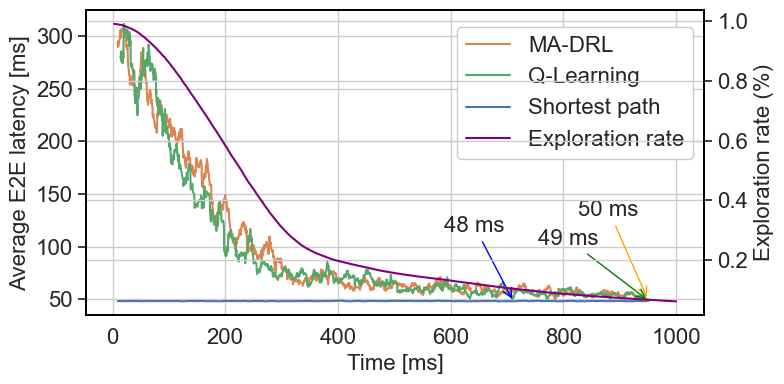

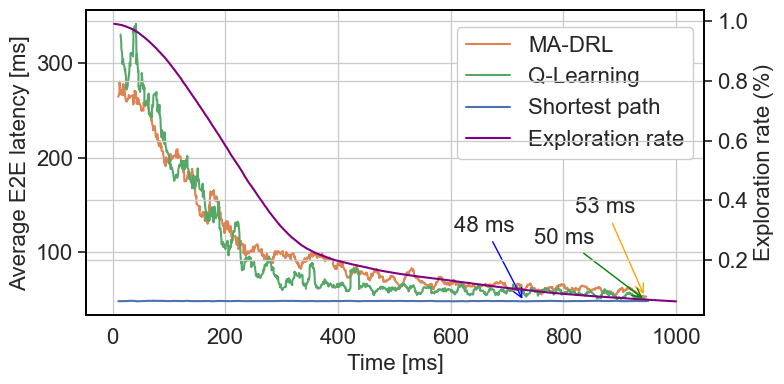

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def extract_block_index(block_id):
    return int(block_id.split('_')[-1])

def compare_latency_plots_with_epsilon_combined_legend(baseline, madrl, q_learning_path, epsilon_path, window_size=20, marker_size=50, folder_path='./', constellation=''):
    sns.set(font_scale=1.0)
    sns.set_style("whitegrid")

    # Load datasets
    df1_raw_base = pd.read_csv(baseline)
    df2_raw_madrl = pd.read_csv(madrl)
    q_learning_df = pd.read_csv(q_learning_path)
    epsilon_df = pd.read_csv(epsilon_path)

    # Convert to milliseconds
    for df in [df1_raw_base, df2_raw_madrl, q_learning_df]:
        df['Latency'] *= 1000
        df['Creation Time'] *= 1000
    epsilon_df['time'] *= 1000

    # Process latency data
    for df_raw in [df1_raw_base, df2_raw_madrl, q_learning_df]:
        df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)
        df_raw.sort_values(by=['Source', 'Destination', 'Block Index'], inplace=True)
        df_raw['Path'] = df_raw['Source'].astype(str) + ' -> ' + df_raw['Destination'].astype(str)
        df_raw['Latency_Rolling_Avg'] = df_raw.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())

    # Create subplot for each path
    unique_paths = df1_raw_base['Path'].unique()
    for path in unique_paths:
        plt.figure(figsize=(8, 4))

        # Filter data for the current path
        df1_path_base = df1_raw_base[df1_raw_base['Path'] == path]
        df2_path_madrl = df2_raw_madrl[df2_raw_madrl['Path'] == path]
        q_learning_path_df = q_learning_df[q_learning_df['Path'] == path]

        # Create twin axis for epsilon
        ax1 = plt.gca()
        ax2 = ax1.twinx()

        # Plot latency trends for all three policies
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=df1_path_base, label='Shortest path', markersize=marker_size, ax=ax1)
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=df2_path_madrl, label='MA-DRL', markersize=marker_size, ax=ax1)
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=q_learning_path_df, label='Q-Learning', markersize=marker_size, ax=ax1)

        # Plot epsilon trend
        sns.lineplot(x='time', y='epsilon', data=epsilon_df, color='purple', label='Exploration rate', ax=ax2)

        # Find and annotate minimum latency values for each dataset
        min_values = [
            (df1_path_base, 'blue', (-50, 50)),
            (df2_path_madrl, 'orange', (-50, 60)),
            (q_learning_path_df, 'green', (-80, 40))
        ]
        for df, color, offset in min_values:
            min_latency = df['Latency_Rolling_Avg'].min()
            min_pos = df['Creation Time'][df['Latency_Rolling_Avg'].idxmin()]
            ax1.annotate(f'{min_latency:.0f} ms', xy=(min_pos, min_latency), xytext=offset, textcoords='offset points', arrowprops=dict(arrowstyle='->', color=color), fontsize=16)

        # Remove individual legends if they exist
        if ax1.get_legend() is not None:
            ax1.get_legend().remove()
        if ax2.get_legend() is not None:
            ax2.get_legend().remove()

        # Get handles and labels
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()

        # Reorder the items in the legend
        handles_reordered = [handles1[1], handles1[2], handles1[0], handles2[0]]
        labels_reordered = [labels1[1], labels1[2], labels1[0], labels2[0]]

        # Create a new legend with the reordered handles and labels
        ax1.legend(handles_reordered, labels_reordered, loc='upper right', bbox_to_anchor=(1, 0.98), frameon=True, facecolor='white', framealpha=1, fontsize=16)

        # Set plot titles and labels
        path = path.replace("->", "to")
        path = path.replace('Northwest Territories, ', '')
        ax1.set_xlabel('Time [ms]', fontsize=16)
        ax1.set_ylabel('Average E2E latency [ms]', fontsize=16)
        ax2.set_ylabel('Exploration rate (%)', fontsize=16)

        ax1.tick_params(axis='both', which='major', labelsize=16)
        ax2.tick_params(axis='both', which='major', labelsize=16)

        # Make the plot border black
        for spine in ax1.spines.values():
            spine.set_edgecolor('black')
        for spine in ax2.spines.values():
            spine.set_edgecolor('black')

        plt.tight_layout()
        plt.savefig(f'{folder_path}{constellation}_{path}.png', dpi=300)
        plt.show()
        plt.close()

    sns.set(font_scale=1.0)

constellation = 'Starlink'  # [Kepler, Iridium, OneWeb, Starlink]
folder_path = './2GTsOffline/'
compare_latency_plots_with_epsilon_combined_legend(
    f'{folder_path}allLatencies_2_gateways_DataRate_{constellation}.csv',
    f'{folder_path}allLatencies_2_gateways_DRL_{constellation}.csv',
    f'{folder_path}allLatencies_2_gateways_Q_{constellation}.csv',
    epsilon_path=f'{folder_path}epsilons_2_gateways_{constellation}.csv',
    window_size=20, marker_size=50, folder_path=folder_path, constellation=constellation)


## No MA-DRL

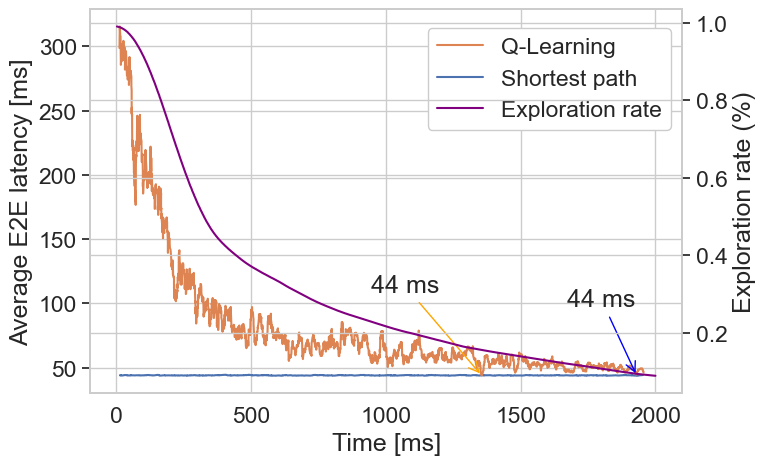

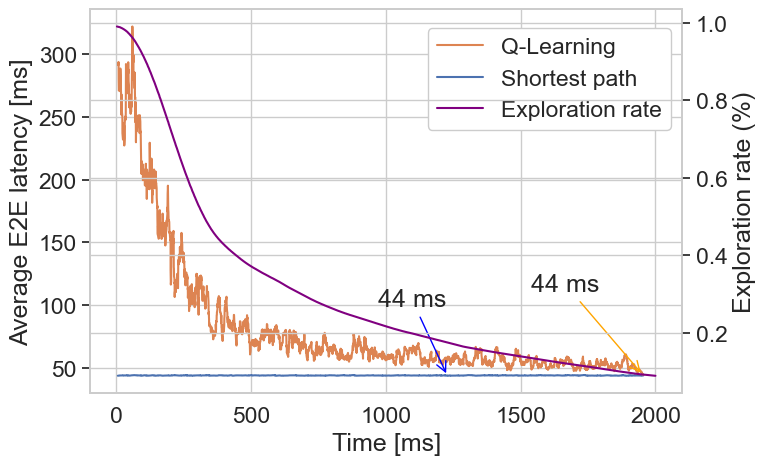

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def extract_block_index(block_id):
    return int(block_id.split('_')[-1])

def compare_latency_plots_with_epsilon_combined_legend(baseline, q_learning_path, epsilon_path, window_size=20, marker_size=50, folder_path='./', constellation=''):
    sns.set(font_scale=1.0)
    sns.set_style("whitegrid")

    # Load datasets
    df1_raw_base = pd.read_csv(baseline)
    q_learning_df = pd.read_csv(q_learning_path)
    epsilon_df = pd.read_csv(epsilon_path)

    # Convert to milliseconds
    for df in [df1_raw_base, q_learning_df]:
        df['Latency'] *= 1000
        df['Creation Time'] *= 1000
    epsilon_df['time'] *= 1000
    

    # Process latency data
    for df_raw in [df1_raw_base, q_learning_df]:
        df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)
        df_raw.sort_values(by=['Source', 'Destination', 'Block Index'], inplace=True)
        df_raw['Path'] = df_raw['Source'].astype(str) + ' -> ' + df_raw['Destination'].astype(str)
        df_raw['Latency_Rolling_Avg'] = df_raw.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())

    # Create subplot for each path
    unique_paths = df1_raw_base['Path'].unique()
    for path in unique_paths:
        plt.figure(figsize=(8, 6), facecolor='white')

        # Filter data for the current path
        df1_path_base = df1_raw_base[df1_raw_base['Path'] == path]
        q_learning_path_df = q_learning_df[q_learning_df['Path'] == path]

        # Create twin axis for epsilon
        ax1 = plt.gca()
        ax2 = ax1.twinx()

        # Plot latency trends for all three policies
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=df1_path_base, label='Shortest path', markersize=marker_size, ax=ax1)
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=q_learning_path_df, label='Q-Learning', markersize=marker_size, ax=ax1)

        # Plot epsilon trend
        sns.lineplot(x='time', y='epsilon', data=epsilon_df, color='purple', label='Exploration rate', ax=ax2)

        # Find and annotate minimum latency values for each dataset
        min_values = [
            (df1_path_base, 'blue', (-50, 50)),
            (q_learning_path_df, 'orange', (-80, 60))
        ]
        for df, color, offset in min_values:
            min_latency = df['Latency_Rolling_Avg'].min()
            min_pos = df['Creation Time'][df['Latency_Rolling_Avg'].idxmin()]
            ax1.annotate(f'{min_latency:.0f} ms', xy=(min_pos, min_latency), xytext=offset, textcoords='offset points', arrowprops=dict(arrowstyle='->', color=color))

            # Remove individual legends if they exist
            if ax1.get_legend() is not None:
                ax1.get_legend().remove()
            if ax2.get_legend() is not None:
                ax2.get_legend().remove()


            # Get handles and labels
            handles1, labels1 = ax1.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()

            # Reorder the items in the legend
            # 'Shortest path' is the first item in labels1, 'MA-DRL' is the second, 'Q-Learning' is the third, and 'Exploration rate' is the first item in labels2
            handles_reordered = [handles1[1], handles1[0], handles2[0]]
            labels_reordered = [labels1[1], labels1[0], labels2[0]]

            # Create a new legend with the reordered handles and labels
            ax1.legend(handles_reordered, labels_reordered, loc='upper right', bbox_to_anchor=(1, 0.98), frameon=True, facecolor='white', framealpha=1)

        # Set plot titles and labels
        path = path.replace("->", "to")
        path = path.replace('Northwest Territories, ', '')
        # plt.title(f'Average latency for {path}')
        ax1.set_xlabel('Time [ms]')
        ax1.set_ylabel('Average E2E latency [ms]')
        ax2.set_ylabel('Exploration rate (%)')

        plt.tight_layout()
        plt.savefig(f'{folder_path}{constellation}_{path}.png', dpi=300)
        plt.show()
        plt.close()

    sns.set(font_scale=1.0)

# compare_latency_plots_with_epsilon_combined_legend('allLatencies_2_gateways_DataRate_Shifted.csv', 'allLatencies_2_gateways_shifted_DRL.csv', 'Q-Learning_Kepler.csv', 'epsilons_2_gateways_Kepler.csv', window_size=20, marker_size=5)
# compare_latency_plots_with_epsilon_combined_legend('DataRate_Kepler.csv', 'AGP-LA_DRL_Kepler.csv', 'Q-Learning_Kepler.csv', 'epsilons_2_gateways_Kepler.csv', window_size=20, marker_size=5)
constellation = 'Kepler' # [Kepler, Iridium, OneWeb, Starlink]
folder_path   = './2GTsOffline/'
compare_latency_plots_with_epsilon_combined_legend(f'{folder_path}allLatencies_2_gateways_DataRate_{constellation}.csv', 
                                                   f'{folder_path}allLatencies_2_gateways_Q_{constellation}.csv', 
                                                   epsilon_path=f'{folder_path}epsilons_2_gateways_{constellation}.csv', 
                                                   window_size=20, marker_size=50, folder_path=folder_path,constellation=constellation)


# Movement

Maximum Creation Time: 96.50667503628783


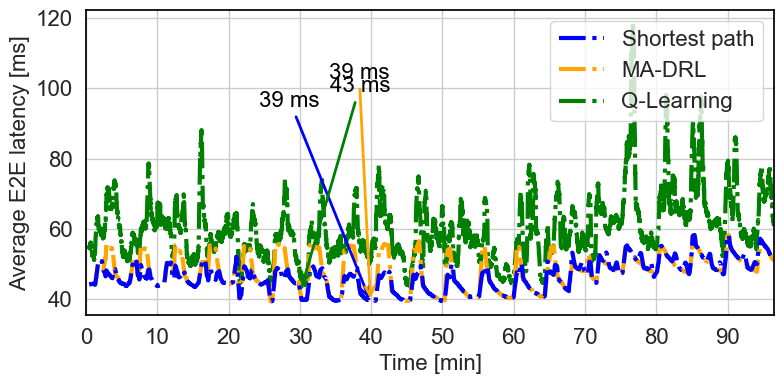

Maximum Creation Time: 96.5142857885587


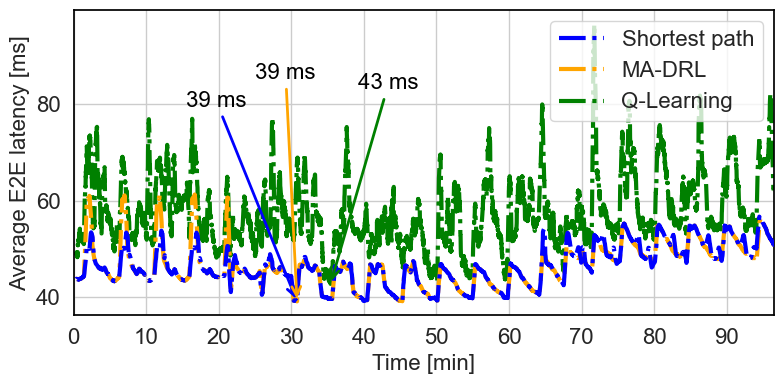

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def extract_block_index(block_id):
    return int(block_id.split('_')[-1])

def compare_latency_plots_with_epsilon_combined_legend_no_eps(baseline, madrl, q_learning_path, epsilon_path=None, window_size=20, marker_size=50):
    sns.set(font_scale=1.0)
    sns.set_style("whitegrid")

    # Load datasets
    df1_raw_base = pd.read_csv(baseline)
    df2_raw_madrl = pd.read_csv(madrl)
    q_learning_df = pd.read_csv(q_learning_path)

    # Convert to milliseconds
    for df in [df1_raw_base, df2_raw_madrl, q_learning_df]:
        df['Latency'] *= 1000
        df['Creation Time'] *= (5805.44/(60*20))

    # Process latency data
    for df_raw in [df1_raw_base, df2_raw_madrl, q_learning_df]:
        df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)
        df_raw.sort_values(by=['Source', 'Destination', 'Block Index'], inplace=True)
        df_raw['Path'] = df_raw['Source'].astype(str) + ' -> ' + df_raw['Destination'].astype(str)
        df_raw['Latency_Rolling_Avg'] = df_raw.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())

    epsilon_df_loaded = False
    if epsilon_path is not None:
        epsilon_df = pd.read_csv(epsilon_path)
        epsilon_df_loaded = True

    # Create subplot for each path
    unique_paths = df1_raw_base['Path'].unique()
    for path in unique_paths:
        plt.figure(figsize=(8, 4))

        # Filter data for the current path
        df1_path_base = df1_raw_base[df1_raw_base['Path'] == path]
        df2_path_madrl = df2_raw_madrl[df2_raw_madrl['Path'] == path]
        q_learning_path_df = q_learning_df[q_learning_df['Path'] == path]

        # Create twin axis for epsilon
        ax1 = plt.gca()
        if epsilon_df_loaded:
            ax2 = ax1.twinx()

        # Plot latency trends for all three policies
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=df1_path_base, label='Shortest path', markersize=marker_size, linestyle='-.', ax=ax1, color='blue', zorder=3, lw=3)
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=df2_path_madrl, label='MA-DRL', markersize=marker_size, linestyle='-.', ax=ax1, color='orange', zorder=2, lw=3)
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=q_learning_path_df, label='Q-Learning', markersize=marker_size, linestyle='-.', ax=ax1, color='green', zorder=1, lw=3)

        # Plot epsilon trend if data is loaded
        if epsilon_df_loaded:
            sns.lineplot(x='time', y='epsilon', data=epsilon_df, color='purple', label='Exploration rate', ax=ax2)
            ax2.set_ylabel('Exploration rate (%)', fontsize=16)

        # Annotate minimum latency values for each dataset
        min_values = [
            (df1_path_base, 'blue', (-80, 140)),
            (df2_path_madrl, 'orange', (-30, 160)),
            (q_learning_path_df, 'green', (20, 140))
        ]
        for df, color, offset in min_values:
            min_latency = df['Latency_Rolling_Avg'].min()
            min_pos = df['Creation Time'][df['Latency_Rolling_Avg'].idxmin()]
            ax1.annotate(f'{min_latency:.0f} ms', xy=(min_pos, min_latency), xytext=offset, textcoords='offset points', arrowprops=dict(arrowstyle='->', color=color, lw=2), color='black', fontsize=16)

        # Handling legends and labels
        handles1, labels1 = ax1.get_legend_handles_labels()
        if epsilon_df_loaded:
            handles2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right', fontsize=16)
        else:
            ax1.legend(handles1, labels1, loc='upper right', fontsize=16)

        # Set plot titles and labels
        ax1.set_xlabel('Time [min]', fontsize=16)
        ax1.set_ylabel('Average E2E latency [ms]', fontsize=16)

        ax1.tick_params(axis='both', which='major', labelsize=16)
        if epsilon_df_loaded:
            ax2.tick_params(axis='both', which='major', labelsize=16)

        # Set x-axis to start at 0 and end at the last value
        max_creation_time = max(df1_path_base['Creation Time'].max(), df2_path_madrl['Creation Time'].max(), q_learning_path_df['Creation Time'].max())
        ax1.set_xlim(left=0, right=max_creation_time)
        ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
        print(f'Maximum Creation Time: {max_creation_time}')

        # Make the plot border black
        for spine in ax1.spines.values():
            spine.set_edgecolor('black')
        if epsilon_df_loaded:
            for spine in ax2.spines.values():
                spine.set_edgecolor('black')

        plt.tight_layout()
        plt.savefig(f'./rotation/{path.replace(" -> ", "_to_")}_Movement.png', dpi=300)
        plt.show()
        plt.close()

    sns.set(font_scale=1.0)

compare_latency_plots_with_epsilon_combined_legend_no_eps(
    './rotation/allLatencies_2_gateways_Kepler.csv',
    './rotation/allLatencies_2_gateways_MADRL.csv',
    './rotation/allLatencies_2_gateways_Q2.csv',
    window_size=150, marker_size=50
)


# 8 GTs no congestion learning

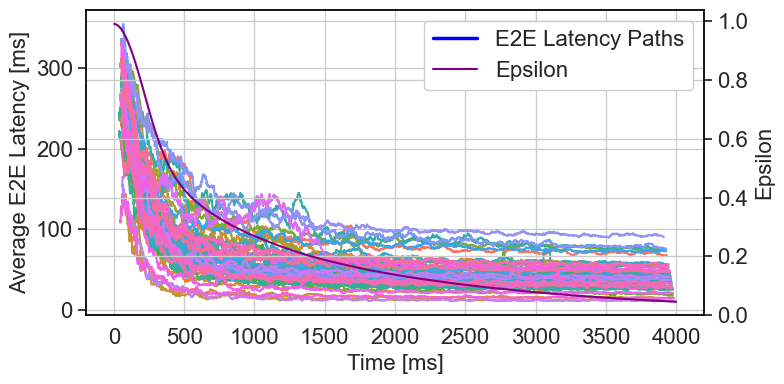

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D

class HandlerMultiColorLine(HandlerLine2D):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Define a list of colors for the multi-color line
        colors = ['red', 'green', 'blue']  # Modify as per your color scheme used in the plot
        lw = 2.5  # Line width
        x = [xdescent + width / 5 * (i + 1) for i in range(len(colors))]
        y = [0.5 * height for _ in range(len(colors))]
        leglines = [plt.Line2D([xi], [y[i]], color=colors[i], lw=lw) for i, xi in enumerate(x)]
        for legline in leglines:
            legline.set_transform(trans)
        return leglines

def plotSaveLatenciesByCreationTime(outputPath, allLatenciesDF, epsDF, window_size, annotate_min=False):
    # Set visual settings
    sns.set(font_scale=1.0)
    sns.set_style("whitegrid")
    
    # Convert time values to milliseconds
    allLatenciesDF['Creation Time'] *= 1000
    allLatenciesDF['Latency'] *= 1000
    epsDF['time'] *= 1000
    
    # Calculate rolling average latency
    allLatenciesDF['Path'] = allLatenciesDF['Source'].astype(str) + ' -> ' + allLatenciesDF['Destination'].astype(str)
    allLatenciesDF.sort_values(by='Creation Time', inplace=True)
    allLatenciesDF['Latency_Rolling_Avg'] = allLatenciesDF.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())

    # Plot latency
    plt.figure(figsize=(8, 4), facecolor='white')
    ax1 = sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', hue='Path', data=allLatenciesDF, legend=None)  # Disable automatic legend
    ax2 = ax1.twinx()
    epsilon_plot, = ax2.plot(epsDF['time'], epsDF['epsilon'], color='purple', label='Epsilon')  # Epsilon plot

    # Set the axis labels
    ax1.set_xlabel('Time [ms]', fontsize=16)
    ax1.set_ylabel('Average E2E Latency [ms]', fontsize=16)
    ax2.set_ylabel('Epsilon', fontsize=16)
    ax2.set_ylim(bottom=0)

    # Set the tick parameters for both axes
    ax1.tick_params(axis='both', labelsize=16)
    ax2.tick_params(axis='both', labelsize=16)

    # Create custom handles for the legend
    latency_handle = Line2D([0], [0], color='blue', lw=2.5, label='E2E Latency')
    epsilon_handle = epsilon_plot

    # Create the legend with custom handlers
    ax2.legend(handles=[latency_handle, epsilon_handle], 
               labels=['E2E Latency Paths', 'Epsilon'],
               handler_map={latency_handle: HandlerLine2D(), epsilon_handle: HandlerLine2D()}, 
               loc='upper right', facecolor='white', framealpha=1, fontsize=16)

    # Annotate minimum latencies
    if annotate_min:
        for path in allLatenciesDF['Path'].unique():
            path_df = allLatenciesDF[allLatenciesDF['Path'] == path]
            min_latency_row = path_df.loc[path_df['Latency_Rolling_Avg'].idxmin()]
            ax1.text(min_latency_row['Creation Time'], min_latency_row['Latency_Rolling_Avg'], 
                     f'{min_latency_row["Latency_Rolling_Avg"]:.2f}', 
                     horizontalalignment='right', size='small', color='black', weight='semibold', fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Make the plot border black
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')

    # Save plot
    plt.savefig(os.path.join(outputPath, 'learning_8_gateways_NoCongestion.png'), bbox_inches='tight')
    plt.show()
    plt.close()

# Example usage
nGTs = 8
path = f'./8GTs_Explore/'
allLatenciesDF = pd.read_csv(f'{path}/allLatencies_{nGTs}_gateways_learning.csv')
epsDF = pd.read_csv(f'{path}/epsilons_{nGTs}_gateways.csv')
plotSaveLatenciesByCreationTime(f'{path}/', allLatenciesDF, epsDF, window_size=50, annotate_min=False)


# 8 GTs comparison

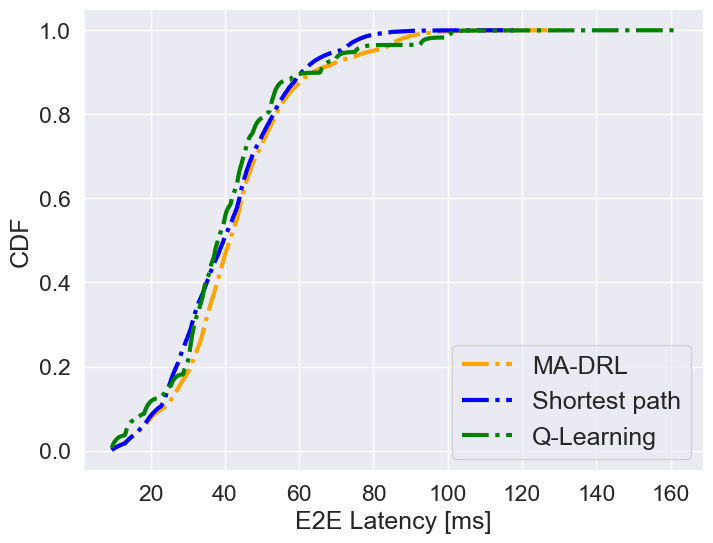

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def save_latency_comparison_plot(drl_path, data_rate_path, output_path, q_learning_path=None, plot_all_components=True):
    # Read the data for MA-DRL and Shortest Path
    drl_data = pd.read_csv(drl_path)
    data_rate_data = pd.read_csv(data_rate_path)

    # Optionally read Q-Learning data if provided
    if q_learning_path:
        q_learning_data = pd.read_csv(q_learning_path)

    # Convert seconds to milliseconds by multiplying the relevant columns by 1000
    components = ['QueueTime', 'PropTime', 'TxTime', 'Latency']
    for component in components:
        drl_data[component] *= 1000
        data_rate_data[component] *= 1000
        if q_learning_path:
            q_learning_data[component] *= 1000
    
    # Select which components to plot based on the flag
    plot_components = ['Latency'] if not plot_all_components else components
    line_styles = {'QueueTime': '--', 'PropTime': '-.', 'TxTime': ':', 'Latency': '-.'}
    colors = {'MA-DRL': 'orange', 'Shortest path': 'blue', 'Q-Learning': 'green'}
    
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 22, 'legend.fontsize': 18})
    
    for component in plot_components:
        for method, color in colors.items():
            if method == 'MA-DRL':
                data = drl_data
            elif method == 'Shortest path':
                data = data_rate_data
            elif method == 'Q-Learning' and q_learning_path:
                data = q_learning_data
            else:
                continue

            values, base = np.histogram(data[component], bins=1000, density=True)
            cdf = np.cumsum(values) * np.diff(base)
            label = f'{method} - {component}' if component != 'Latency' else f'{method}'
            plt.plot(base[:-1], cdf, label=label, color=color, linestyle=line_styles[component], linewidth=3 if component == 'Latency' else 2)
    
    # Setting up the plot labels and title
    plt.xlabel('E2E Latency [ms]')
    plt.ylabel('CDF')
    plt.legend()
    plt.grid(True)
    
    # Saving the plot
    plt.savefig(output_path + '/8GTs_Exploit/No_congestion_CDF.png')
    plt.show()
    plt.close()

# Example usage with Q-Learning data
save_latency_comparison_plot('./8GTs_Exploit/allLatencies_8_gateways_offline.csv', './8GTs_Exploit/allLatencies_8_gateways_DataRate.csv', './', './8GTs_Exploit/allLatencies_8_gateways_QLearning.csv', plot_all_components=False)
# save_latency_comparison_plot('./8GTs_Exploit/allLatencies_8_gateways_offline.csv', './8GTs_Exploit/allLatencies_8_gateways_DataRate.csv', './', q_learning_path=None, plot_all_components=False)


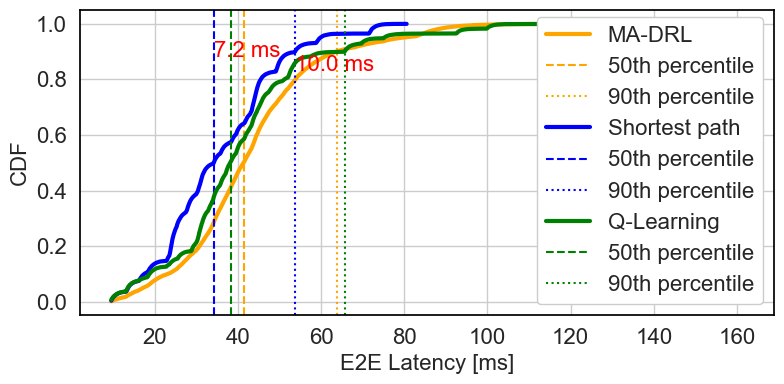

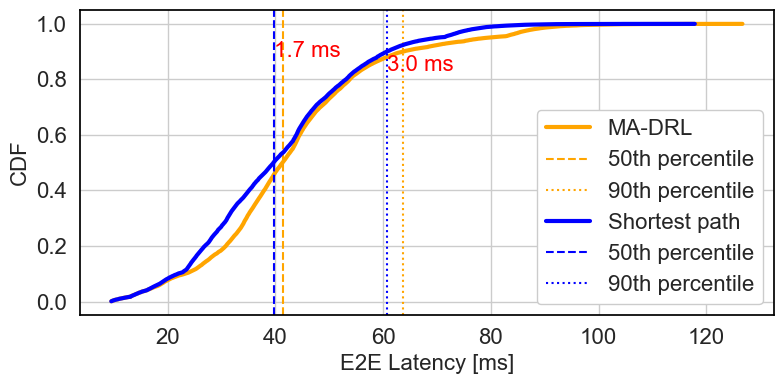

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def save_latency_comparison_plot(drl_path, data_rate_path, output_path, q_learning_path=None, plot_all_components=True):
    # Read the data for MA-DRL and Shortest Path
    drl_data = pd.read_csv(drl_path)
    data_rate_data = pd.read_csv(data_rate_path)

    # Optionally read Q-Learning data if provided
    q_learning_data = None
    if q_learning_path is not None:
        q_learning_data = pd.read_csv(q_learning_path)

    # Convert seconds to milliseconds by multiplying the relevant columns by 1000
    components = ['QueueTime', 'PropTime', 'TxTime', 'Latency']
    for component in components:
        drl_data[component] *= 1000
        data_rate_data[component] *= 1000
        if q_learning_data is not None:
            q_learning_data[component] *= 1000
    
    # Set visual settings
    sns.set(font_scale=1.0)
    sns.set_style("whitegrid")

    # Create a plot
    plt.figure(figsize=(8, 4), facecolor='white')

    # Plot styles
    line_styles = {'QueueTime': '--', 'PropTime': '-.', 'TxTime': ':', 'Latency': '-'}
    colors = {'MA-DRL': 'orange', 'Shortest path': 'blue', 'Q-Learning': 'green' if q_learning_path else None}

    # Percentile dictionary
    percentile_lines = {}

    # Plotting CDF and calculating percentiles
    for method, color in colors.items():
        if method == 'MA-DRL':
            data = drl_data
        elif method == 'Shortest path':
            data = data_rate_data
        elif method == 'Q-Learning' and q_learning_path:
            data = q_learning_data
        else:
            continue

        values, base = np.histogram(data['Latency'], bins=1000, density=True)
        cdf = np.cumsum(values) * np.diff(base)
        plt.plot(base[:-1], cdf, label=f'{method}', color=color, linestyle=line_styles['Latency'], linewidth=3)

        # Calculate and store percentiles for later use
        percentile_50 = np.percentile(data['Latency'], 50)
        percentile_90 = np.percentile(data['Latency'], 90)
        percentile_lines[method] = (percentile_50, percentile_90)
        plt.axvline(x=percentile_50, color=color, linestyle='--', label=f'50th percentile')
        plt.axvline(x=percentile_90, color=color, linestyle=':', label=f'90th percentile')

    # Calculate and annotate the gaps between the percentiles
    methods = list(percentile_lines.keys())
    if len(methods) > 1:
        gap_50 = abs(percentile_lines[methods[0]][0] - percentile_lines[methods[1]][0])
        gap_90 = abs(percentile_lines[methods[0]][1] - percentile_lines[methods[1]][1])
        plt.text(min(percentile_lines[methods[0]][0], percentile_lines[methods[1]][0]), 0.88, f'{gap_50:.1f} ms', fontsize=16, color='red')
        plt.text(min(percentile_lines[methods[0]][1], percentile_lines[methods[1]][1]), 0.83, f'{gap_90:.1f} ms', fontsize=16, color='red')

    plt.xlabel('E2E Latency [ms]', fontsize=16)
    plt.ylabel('CDF', fontsize=16)
    plt.legend(loc='lower right', facecolor='white', framealpha=1, fontsize=16)
    plt.grid(True)
    
    # Set font size for tick labels
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Make the plot border black
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')

    # Saving the plot
    plt.savefig(os.path.join(output_path, 'No_congestion_CDF.png'), bbox_inches='tight')
    plt.show()
    plt.close()

# Example usage with paths adjusted as needed
save_latency_comparison_plot('./CDF/allLatencies_8_gateways_Offline_01.csv', './CDF/allLatencies_8_gateways_SlantRange.csv', './CDF/', q_learning_path='./CDF/allLatencies_8_gateways_QLearning.csv', plot_all_components=False)
save_latency_comparison_plot('./CDF/allLatencies_8_gateways_Offline_01.csv', './CDF/allLatencies_8_gateways_DataRate_01.csv', './CDF/', q_learning_path=None, plot_all_components=False)
